# 基本信息
在训练集或者验证集中标注了目标信息，可以计算

1、目标的类别

2、目标的尺寸位置(y1,x1,y2,x2)

3、目标的面积

4、宽高比

5、目标的多边形面积

6、面积比

In [1]:
# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
import os, json
import numpy as np
import skimage.draw
import math
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

# Path to data set
DATASET = "D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_2021_1113\\"

class MyConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mask"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + my

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    BACKBONE = "resnet50"
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800  
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 0

    # BACKBONE = "resnet50"
    # BACKBONE_STRIDES = [4, 8, 16, 32, 64]
   # # BACKBONE_STRIDES = [2, 4, 8, 16, 32]
    # RPN_ANCHOR_SCALES = (10, 32, 64, 128, 256)
    # RPN_ANCHOR_STRIDE = 2
    # RPN_NMS_THRESHOLD = 0.9
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    # TRAIN_ROIS_PER_IMAGE = 512

############################################################
#  Dataset
############################################################

class MyDataset(utils.Dataset):

    def print_size(self, poly):
        for p in poly:
            a = np.array(p['all_points_y'])
            height = a.max() - a.min()
            a = np.array(p['all_points_x'])
            width = a.max() - a.min()
            self.areas.append(height * width)
            #if height * width < 4096:
            #    print(width, height)

    def load_my(self, dataset_dir, subset, class_dict):
        """Load a subset of the My dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.areas = []
        # Add classes. We have only one class to add.
        for (k, v) in class_dict.items():
            self.add_class("my", v, k)

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            # print(a['regions'])
            # print(a['filename'])
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                class_ids = [class_dict[r['region_attributes']['type']] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                class_ids = [class_dict[r['region_attributes']['type']] for r in a['regions']]
            self.print_size(polygons)
                    # print(class_ids)
                        

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "my",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)
        self.areas.sort()
        print(np.unique(np.round(np.sqrt(self.areas))))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a my dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "my":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        
        class_ids = np.array(info['class_ids'])
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "my":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\pyth

# 标注目标的正方形尺寸

上面已知标注的目标尺寸与宽高比，可以计算目标的正方形尺寸

$$Size = \lceil \frac {width}{ \sqrt {wh\_ratio}} \rceil$$

尺寸$Size$向上取整。

宽高比$wh\_ratio$设定为小数点后一位，进位后舍弃后面的小数。

In [2]:
def toSquareBox(bbox):
    """bbox:[y1, x1, y2, x2]
    将它按照宽高比转换为正方形
    并调整左上和右下的坐标
    
    正方形的坐标 [y1, x1, y2, x2]
    """
    box_height = bbox[2] - bbox[0]
    box_width = bbox[3] - bbox[1]
    wh_ratio = box_width / box_height
    box_size = box_width / math.sqrt(wh_ratio)
    y1 = int(bbox[0] + box_height / 2 - box_size / 2)
    y2 = int(y1 + box_size)
    x1 = int(bbox[1] + box_width / 2 - box_size / 2)
    x2 = int(x1 + box_size)
    
    return wh_ratio, box_size, box_height * box_width, [y1, x1, y2, x2]


In [3]:
target = {
    'file' : '',
    'gts' : [],
    'objs' : []
}
obj = {
    'class_id' : 1,
    'bbox' : [],
    'bbox_area' : 123,
    'wh_ratio' : 0.34,
    'mask_area' : 123,
    'mask_ratio' : 0.1,
    'score' : 1
}
config = MyConfig()
class_dict = {}
label_file = open(DATASET+'label.txt')
label_lines = label_file.readlines()
label_id = 1
for label_line in label_lines:
    label_line = label_line.replace('\n', '')
    class_dict[label_line] = label_id
    label_id = label_id + 1
# Validation dataset
dataset_val = MyDataset()
dataset_val.load_my(DATASET, "train", class_dict)
dataset_val.prepare()
gt_targets = []
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    #print(dataset_val.image_reference(image_id))
    # 针对一个样本的
    target = {
        'file' : dataset_val.image_reference(image_id),
        'gts' : [],
        'objs' : []
    }
    # 处理每个标注目标
    for i in range(0,len(gt_class_id)):
        wh_ratio, box_size, box_area, square_box = toSquareBox(gt_box[i])
        mask_area = np.sum(gt_mask[:,:,i]==True)
        mask_ratio = mask_area / box_area
        obj = {}
        obj['class_id'] = gt_class_id[i]
        obj['bbox'] = gt_box[i]
        obj['bbox_area'] = box_area
        obj['wh_ratio'] = wh_ratio
        obj['mask_area'] = mask_area
        obj['mask_ratio'] = mask_ratio
        obj['size'] = box_size
        target['gts'].append(obj)
        # print(gt_class_id[i], gt_box[i], box_area, box_ratio, mask_area, mask_ratio)
    gt_targets.append(target)
# 按照类别再把尺寸和宽高比分组
for target in gt_targets:
    target['gt_wh_ratios'] = []
    target['gt_sizes'] = []
    target['gt_mask_area'] = []
    target['gt_mask_ratio'] = []
    for i in range(0, 8):
        #target['obj_sizes'] = [obj['size'] for obj in target['objs'] if obj['class_id'] == 7]
        #target['obj_wh_ratios'] = [obj['wh_ratio'] for obj in target['objs'] if obj['class_id'] == 7]
        target['gt_wh_ratios'].append([gt['wh_ratio'] for gt in target['gts'] if gt['class_id'] == i])#gt_wh_ratios
        target['gt_sizes'].append([gt['size'] for gt in target['gts'] if gt['class_id'] == i])#gt_wh_ratiosgt_sizes
        target['gt_mask_area'].append([gt['mask_area'] for gt in target['gts'] if gt['class_id'] == i])
        target['gt_mask_ratio'].append([gt['mask_ratio'] for gt in target['gts'] if gt['class_id'] == i])



[ 40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.
  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123.
 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137.
 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 164. 165. 166.
 167. 168. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 184. 185. 186. 191. 192. 200.]


# 尺寸与宽高比分布

横坐标为尺寸，纵坐标为宽高比，每个类别绘制一个坐标图

主要查看目标的分布情况，同类目标应该在坐标图上聚集一起。

如果存在散漫的点，估计是标注错误。

1128


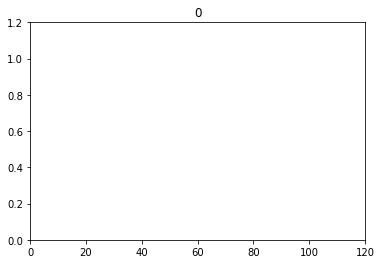

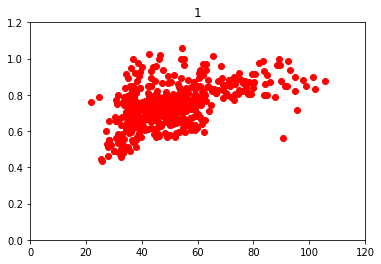

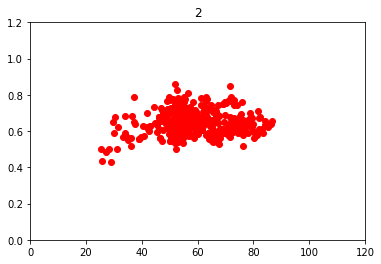

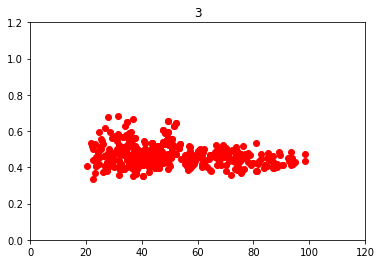

In [4]:
import matplotlib.pyplot as plt
plt.cla()
plt.clf()
plt.close()
print(len(gt_targets))
for i in range(0, 4):
    for target in gt_targets:
        # plt.title(target['file'])
        #print('标注目标尺寸：', np.sort(target['obj_sizes']))
        #print('标注目标宽高比：', np.sort(target['obj_wh_ratios']))
        plt.plot(target['gt_sizes'][i], target['gt_wh_ratios'][i], 'ro')
        #plt.plot(target['obj_sizes'], target['obj_wh_ratios'], 'go')
        plt.axis([0, 120, 0, 1.2])
    plt.title(i)
    plt.show()


# 标注像素面积与宽高比的分布

横坐标为标注目标的像素个数和，纵坐标为宽高比，每个类别绘制一个坐标图。

主要查看目标的Mask情况，同类目标应该在坐标图上聚集一起。

如果存在散漫的点，估计是标注错误。

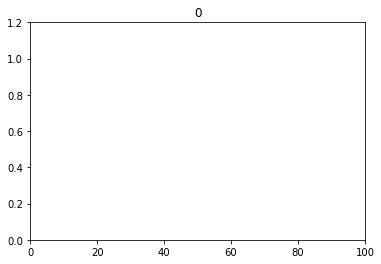

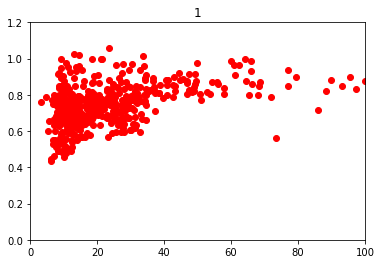

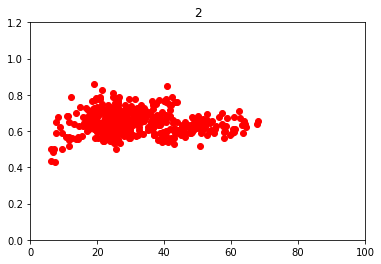

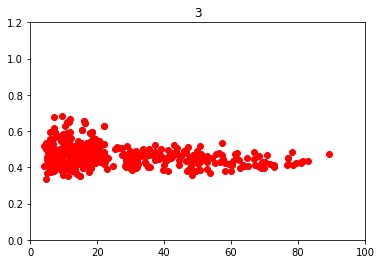

In [5]:
for i in range(0, 4):
    for target in gt_targets:
        # plt.title(target['file'])
        #print('标注目标尺寸：', np.sort(target['obj_sizes']))
        #print('标注目标宽高比：', np.sort(target['obj_wh_ratios']))
        plt.plot(np.array(target['gt_mask_area'][i])/100, target['gt_wh_ratios'][i], 'ro')
        #plt.plot(target['obj_sizes'], target['obj_wh_ratios'], 'go')
        plt.axis([0, 100, 0, 1.2])
    plt.title(i)
    plt.show()


# 标注像素面积占比与宽高比的分布

横坐标为标注目标的像素占比（标注的像素面积与矩形包围框面积的比例），纵坐标为宽高比，每个类别绘制一个坐标图。

主要查看目标的分布情况，同类目标应该在坐标图上聚集一起。

如果面积占比很小，表示标注目标有效内容很少，大部分都是背景信息，不利于训练模型。可以考虑重新标注的方式。

如果存在散漫的点，估计是标注错误。

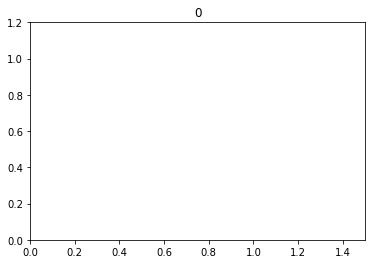

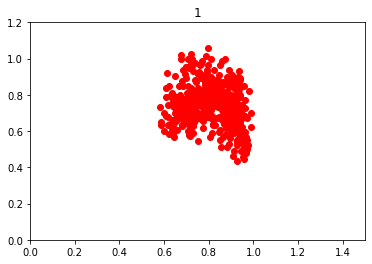

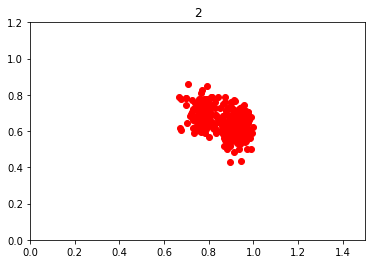

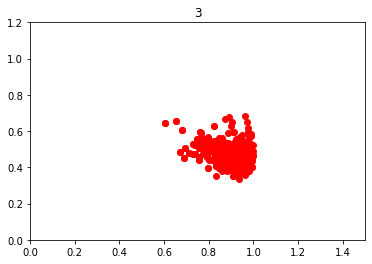

In [6]:
for i in range(0, 4):
    for target in gt_targets:
        # plt.title(target['file'])
        #print('标注目标尺寸：', np.sort(target['obj_sizes']))
        #print('标注目标宽高比：', np.sort(target['obj_wh_ratios']))
        plt.plot(target['gt_mask_ratio'][i], target['gt_wh_ratios'][i], 'ro')
        #plt.plot(target['obj_sizes'], target['obj_wh_ratios'], 'go')
        plt.axis([0, 1.5, 0, 1.2])
    plt.title(i)
    plt.show()


# 目标检测数据

对数据集，如验证集（val）、测试集（test）等都可以，每张图片检测后把结果收集。

检测结果：类别、ROIS、目标框面积、宽高比、掩码面积、面积比、得分

# 目标框

计算GT的bbox与检测的bbox的IoU。

2个目标怎么匹配？IoU最大的那个

# 覆盖测试

人工不可能把所有目标的尺寸和宽高比逐个设置。现实做法是设置几个代表性的尺寸，如32、64、128。代表性的宽高比，如0.5、1、2

代表性数据不可能把所有目标都覆盖（IOU）

根据上述坐标图的数据分布情况，设置代表性尺寸、宽高比，在每个目标上标识最大的交并比（IOU）。

最大交并比（IOU）：理想值就是目标本身，但是以理想值为代表值，必然造成其它目标的交并比（IOU）下降。

三维坐标图：尺寸、宽高比、IOU

尺寸：锚框的正方形尺寸，应该从GT目标中挑选，把尺寸差值小于阈值的目标归为一组，将平均值作为锚框尺寸。目前网络设计，最多只有5个尺寸设置

宽高比：锚框的，也应该从GT目标中挑选。IoU：对所有目标的平均IoU，

理想状态是IOU值足够高（0~1），足以用于目标的过滤。

In [7]:
# 从小到大排序GT目标框尺寸

# 查找GT目标框尺寸的分组位置，即组内尺寸接近

# 代表性的尺寸、宽高比挑选（实验性）

人工设置代表值达到IOU理想状态也不现实。。。

怎么让计算机挑选代表值？